## **Mount Drive**

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Importing Required Libraries**

In [74]:
import numpy as np
import math
import skimage
from skimage import data,io
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
import torch

import math

import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import colorsys

from scipy.sparse import csr_matrix
import scipy.sparse

## ***N-Cut (Similarity Used - Brightness)***



In [75]:
## Function to calculate weight matrix
def get_weight_matrix(img):
  num_rows = img.shape[0]
  num_cols = img.shape[1]

  img_red = img[:,:,0].flatten()
  img_green = img[:,:,1].flatten()
  img_blue = img[:,:,2].flatten()

  length_flatten_list = len(img_red)

  W = np.zeros((length_flatten_list, length_flatten_list))

  sigma_I = 10
  sigma_X = 1e7

  for pixel_1 in range(length_flatten_list):

    F_pixel_1 = ( (img_red[pixel_1]) + (img_green[pixel_1]) + (img_blue[pixel_1]) )/ 3

    for pixel_2 in range(pixel_1 + 1, length_flatten_list):
      pixel_1_idx_i = pixel_1 / num_cols
      pixel_1_idx_j = pixel_1 - pixel_1_idx_i*num_cols

      pixel_2_idx_i = pixel_2 / num_cols
      pixel_2_idx_j = pixel_2 - pixel_2_idx_i*num_cols

      dist_pixel_1_2 = ( (pixel_1_idx_i - pixel_2_idx_i)**2 + (pixel_1_idx_j - pixel_2_idx_j)**2 )**(0.5)

      if dist_pixel_1_2 <= 50:
        F_pixel_2 = ( (img_red[pixel_2]) + (img_green[pixel_2]) + (img_blue[pixel_2]) ) / 3

        W[pixel_1][pixel_2] = math.exp((-1*(F_pixel_1 - F_pixel_2)**2)/sigma_I)  *  math.exp((-1*(dist_pixel_1_2)**2)/sigma_X)
        W[pixel_2][pixel_1] = W[pixel_1][pixel_2]
  return W


In [76]:
## Function to get second smallest eigen value corresponding eigen vector
def get_second_smallest_eigvec(A, B):
  eigvals, eigvecs = scipy.sparse.linalg.eigsh(A, k = 2 ,M = B, which = 'SM')
  second_smallest = eigvecs[:,1]
  return second_smallest

In [77]:
## Function to threshold eigen vector and display image
def threshold_and_display_image(img, second_smallest):
  t = 0
  second_smallest = second_smallest > t
  segmented_img = second_smallest.reshape((img.shape[0], img.shape[1]))
  fig, axs = plt.subplots(ncols=2, squeeze=False, figsize=(15, 15))
  axs[0,0].title.set_text('Original Image')
  axs[0,1].title.set_text('Segmented Image')
  axs[0,0].imshow(img, cmap = 'gray')
  axs[0, 1].imshow(segmented_img, cmap = 'gray')
  plt.show()

In [78]:
def n_cut(img):
  img = skimage.transform.resize(img, (50,50))
  W = get_weight_matrix(img)
  D = np.diag(W.sum(axis = 1))
  A = D-W
  B = D
  second_smallest_eigvec = get_second_smallest_eigvec(A, B)
  return img, W, second_smallest_eigvec

## **N-Cut For Original Images - (Based on Brightness)** 

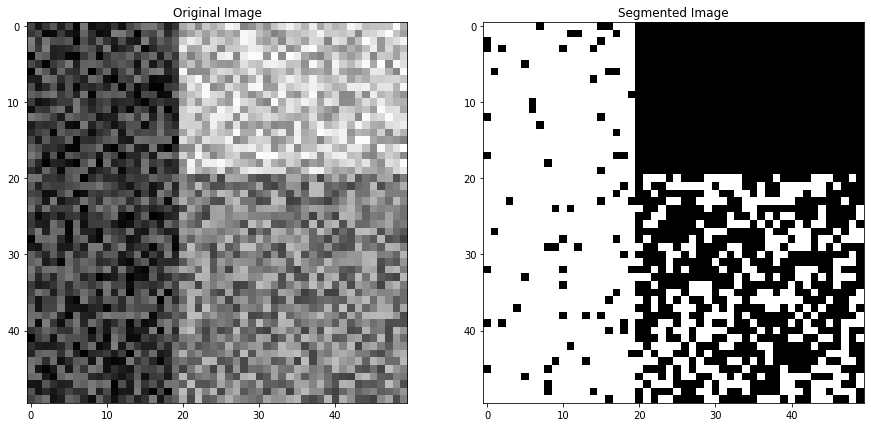

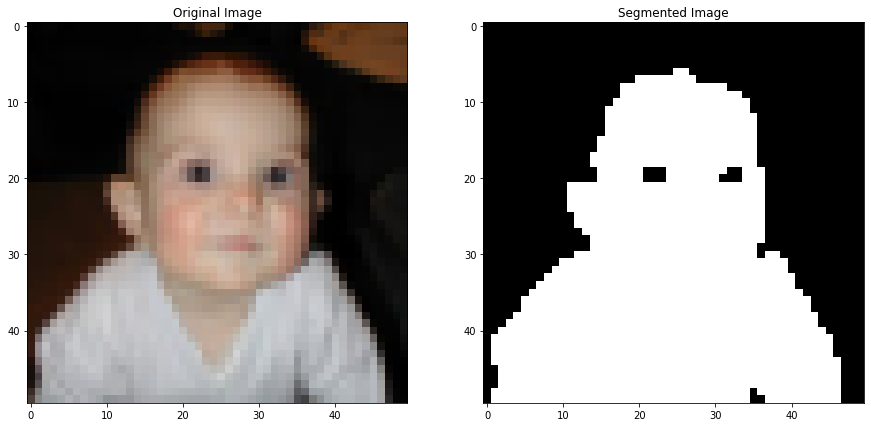

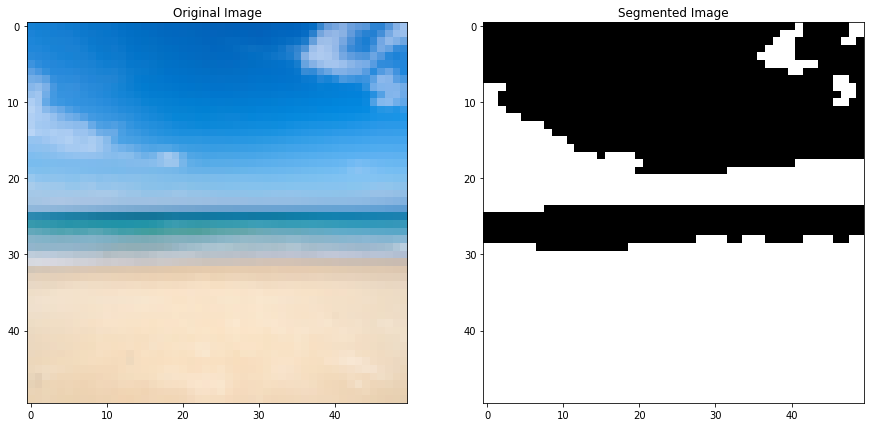

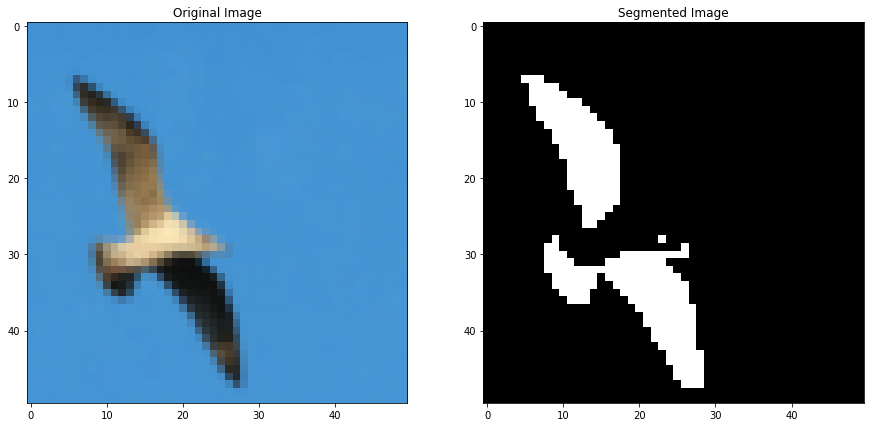

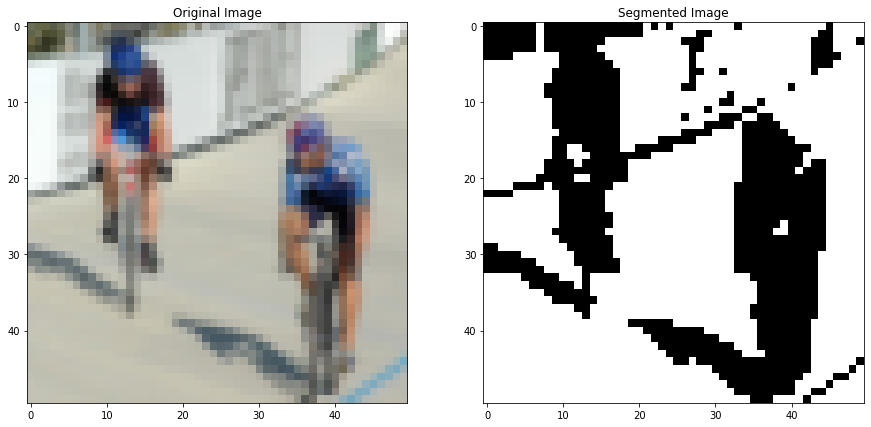

In [79]:
for i in range(1,6):
  if (i == 1):
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.png')
  else:
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.jpg')
  img, W, second_smallest = n_cut(img)
  threshold_and_display_image(img, second_smallest)

## **N-Cut For Rotated Images(Based on Brightness)**

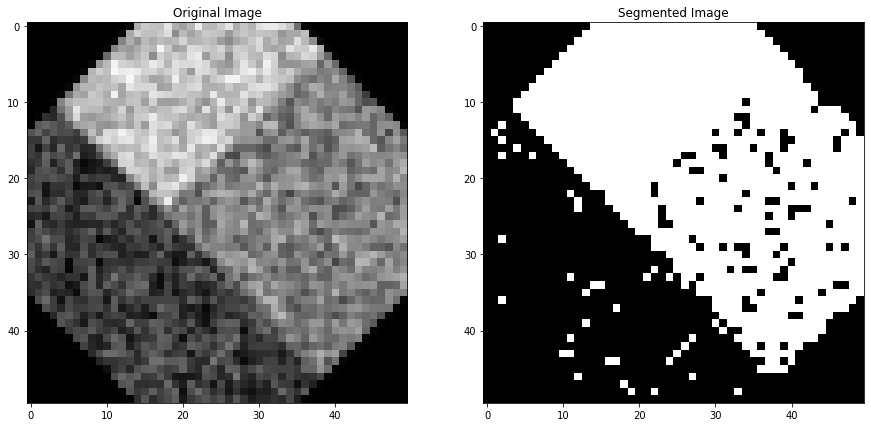

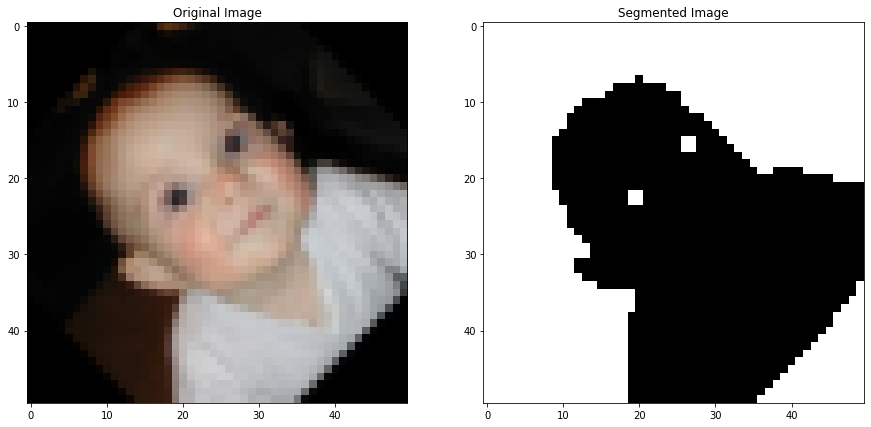

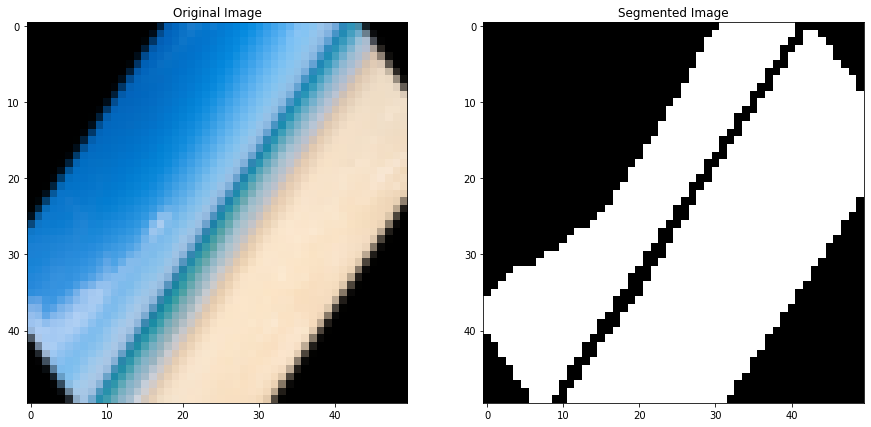

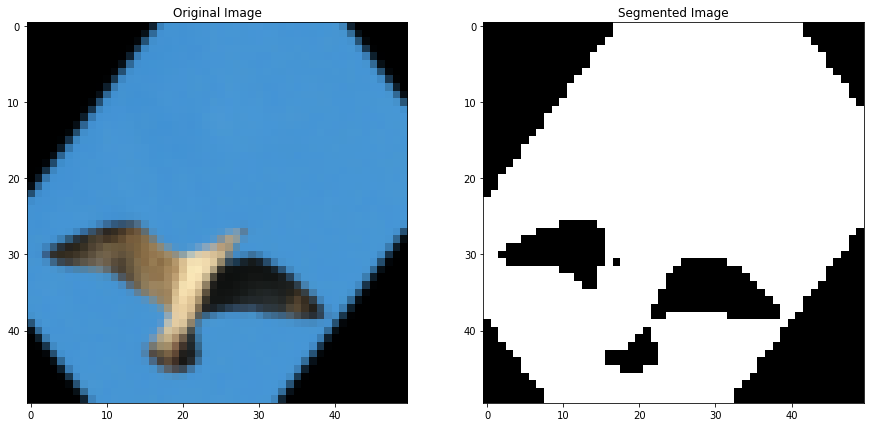

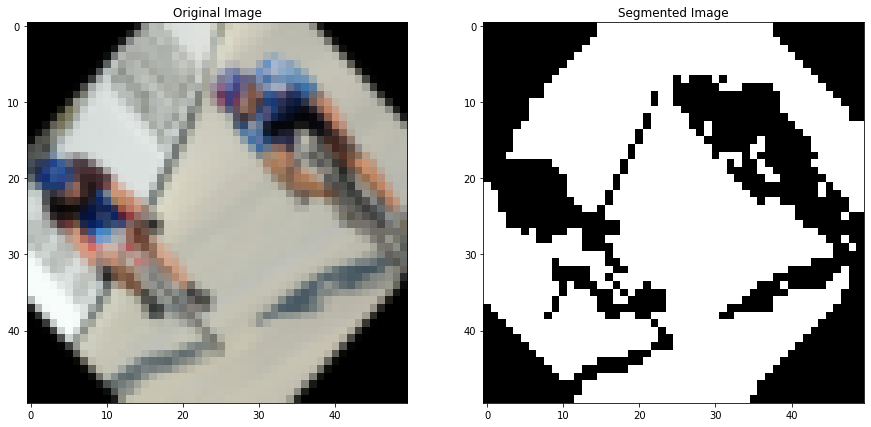

In [80]:
for i in range(1,6):
  if (i == 1):
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.png')
  else:
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.jpg')
  img = skimage.transform.rotate(img,45)
  img, W, second_smallest = n_cut(img)
  threshold_and_display_image(img, second_smallest)

## **N-Cut For Gaussian Blurred Images(Based on Brightness)**

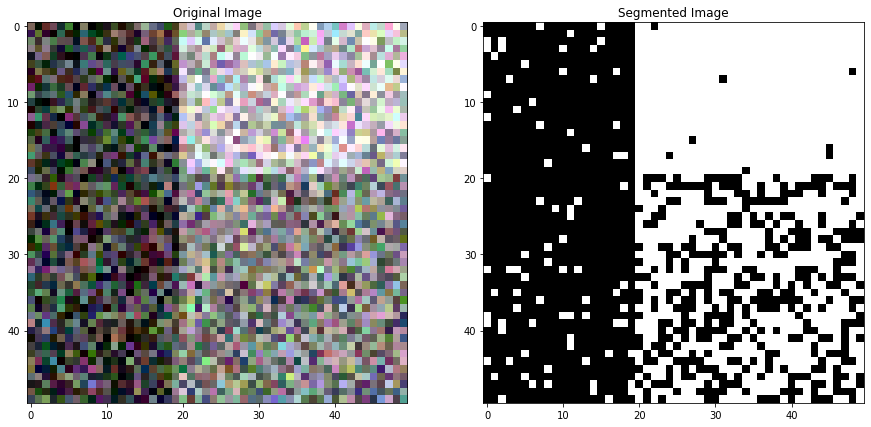

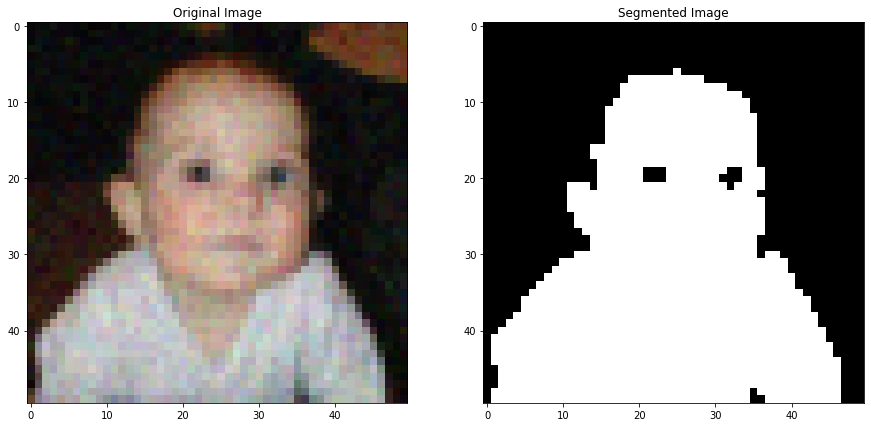

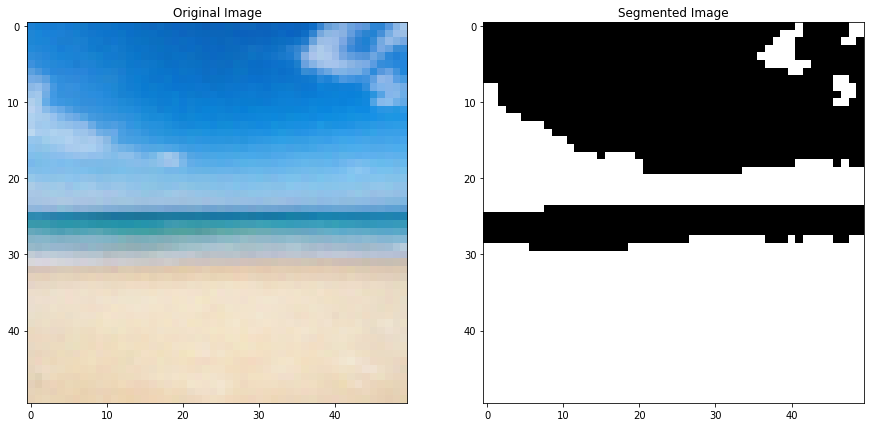

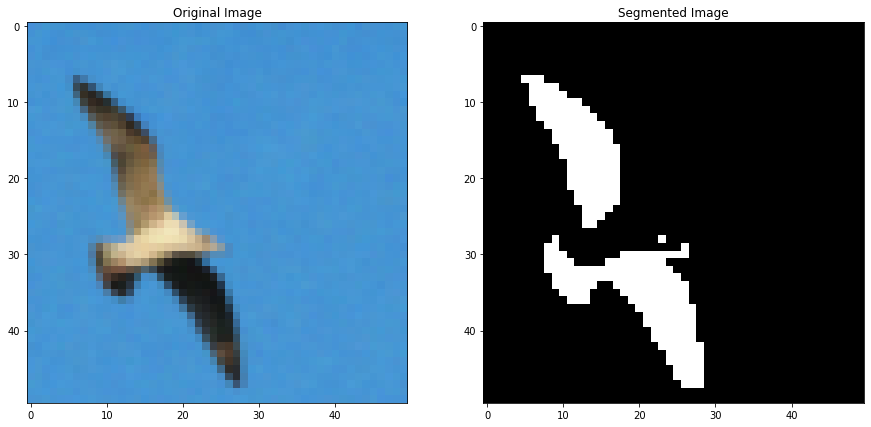

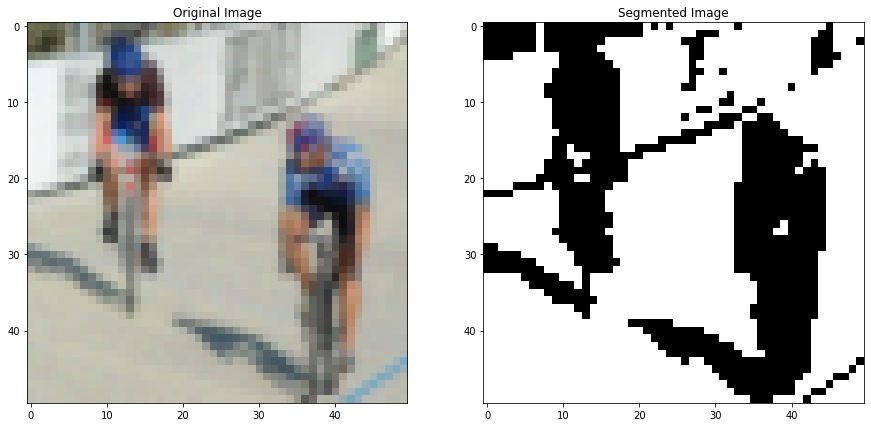

In [81]:
for i in range(1,6):
  if (i == 1):
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.png')
  else:
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.jpg')
  img = skimage.util.random_noise(img, mode='gaussian')
  img, W, second_smallest = n_cut(img)
  threshold_and_display_image(img, second_smallest)

## ***N-Cut (Similarity Used- Color)***

In [82]:
## Function to calculate weight matrix
def get_weight_color_matrix(img):
  num_rows = img.shape[0]
  num_cols = img.shape[1]

  img_red = img[:,:,0].flatten()
  img_green = img[:,:,1].flatten()
  img_blue = img[:,:,2].flatten()

  length_flatten_list = len(img_red)

  W = np.zeros((length_flatten_list, length_flatten_list))

  sigma_I = 10
  sigma_X = 1e7

  for pixel_1 in range(length_flatten_list):
    h_pixel_1,s_pixel_1,v_pixel_1 = colorsys.rgb_to_hsv(img_red[pixel_1], img_green[pixel_1], img_blue[pixel_1])
    F_pixel_1 = np.array([v_pixel_1, v_pixel_1* s_pixel_1*math.sin(h_pixel_1), v_pixel_1* s_pixel_1*math.cos(h_pixel_1) ])

    for pixel_2 in range(pixel_1 + 1, length_flatten_list):
      pixel_1_idx_i = pixel_1 / num_cols
      pixel_1_idx_j = pixel_1 - pixel_1_idx_i*num_cols

      pixel_2_idx_i = pixel_2 / num_cols
      pixel_2_idx_j = pixel_2 - pixel_2_idx_i*num_cols

      dist_pixel_1_2 = ( (pixel_1_idx_i - pixel_2_idx_i)**2 + (pixel_1_idx_j - pixel_2_idx_j)**2 )**(0.5)

      if dist_pixel_1_2 <= 50:
        h_pixel_2,s_pixel_2,v_pixel_2 = colorsys.rgb_to_hsv(img_red[pixel_2], img_green[pixel_2], img_blue[pixel_2])
        F_pixel_2 = np.array([v_pixel_2, v_pixel_2* s_pixel_2*math.sin(h_pixel_2), v_pixel_2* s_pixel_2*math.cos(h_pixel_2) ])

        W[pixel_1][pixel_2] = math.exp((-1*(np.linalg.norm(F_pixel_1 - F_pixel_2))**2)/sigma_I)  *  math.exp((-1*(dist_pixel_1_2)**2)/sigma_X)
        W[pixel_2][pixel_1] = W[pixel_1][pixel_2]
  return W


In [83]:
def n_cut_color(img):
  img = skimage.transform.resize(img, (50,50))
  W = get_weight_color_matrix(img)
  D = np.diag(W.sum(axis = 1))
  A = D-W
  B = D
  second_smallest_eigvec = get_second_smallest_eigvec(A, B)
  return img, W, second_smallest_eigvec

## **N-Cut For Original Images - (Based on Color)** 

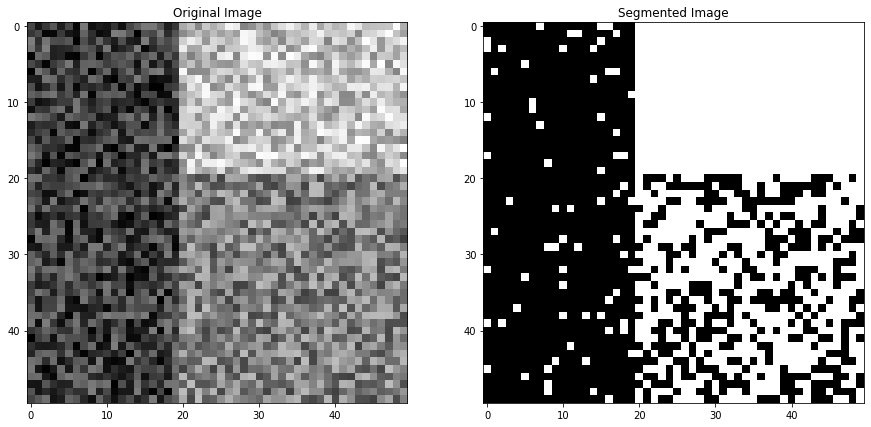

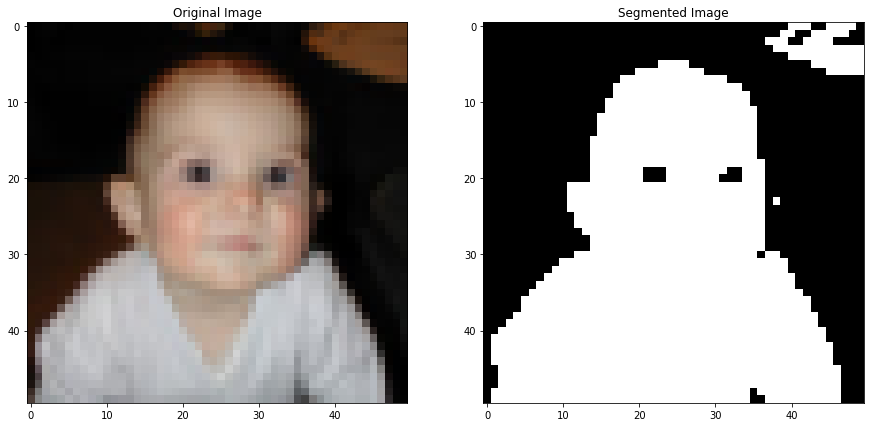

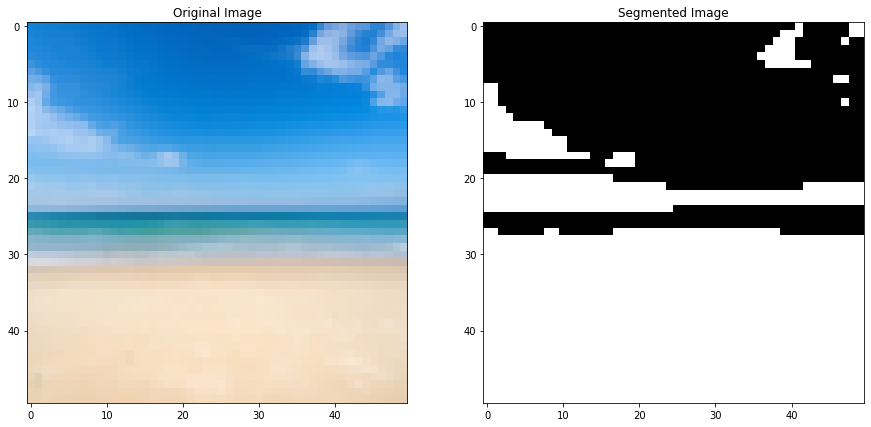

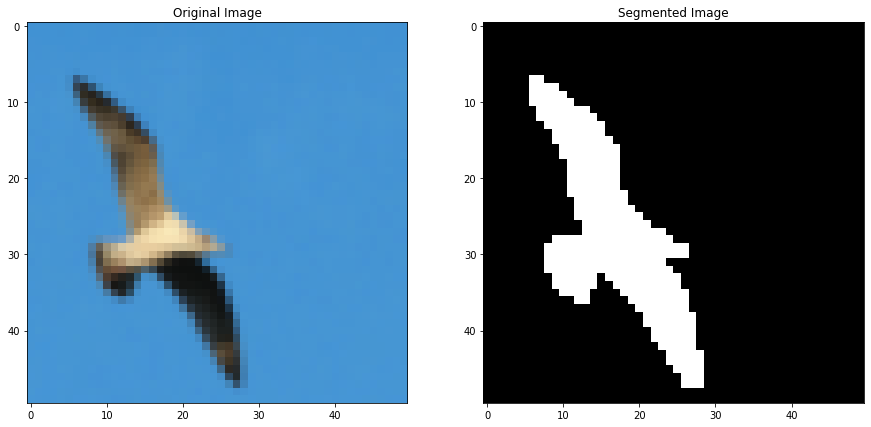

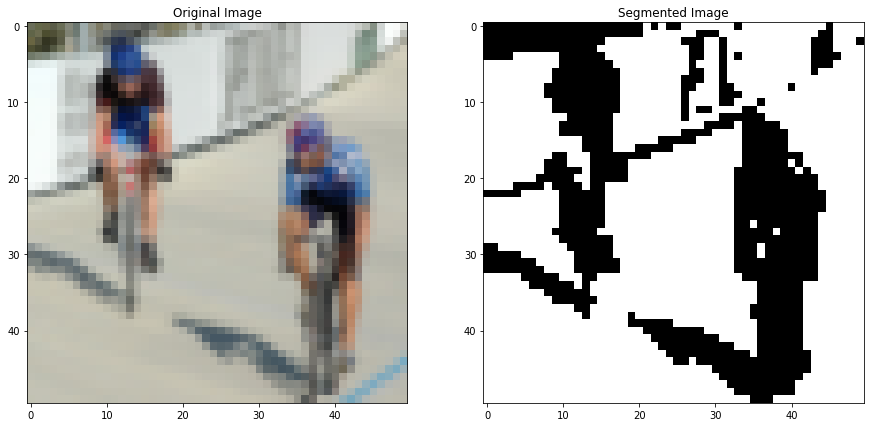

In [84]:
for i in range(1,6):
  if (i == 1):
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.png')
  else:
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.jpg')
  img, W, second_smallest = n_cut_color(img)
  threshold_and_display_image(img, second_smallest)

## **N-Cut For Rotated Images(Based on Color)**

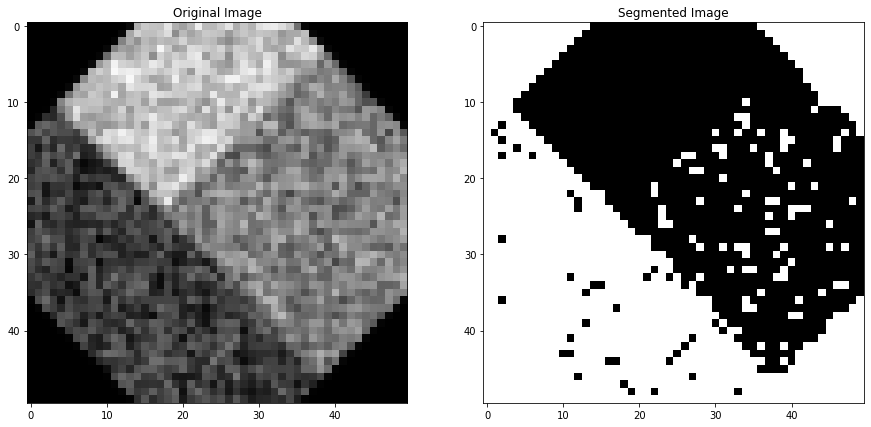

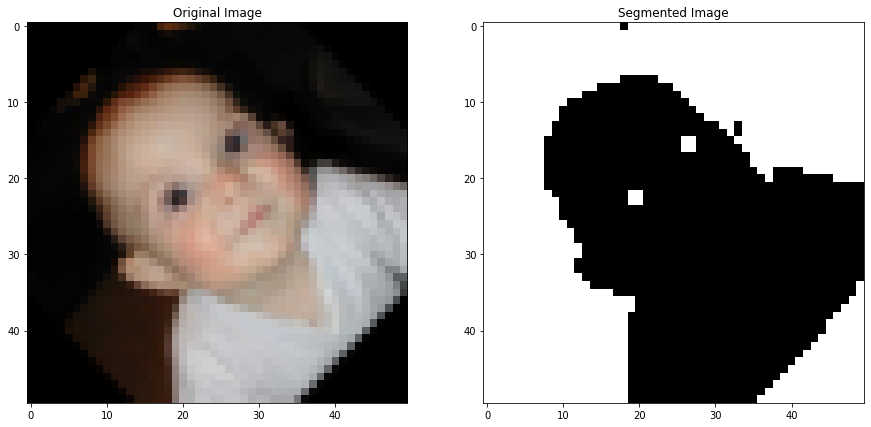

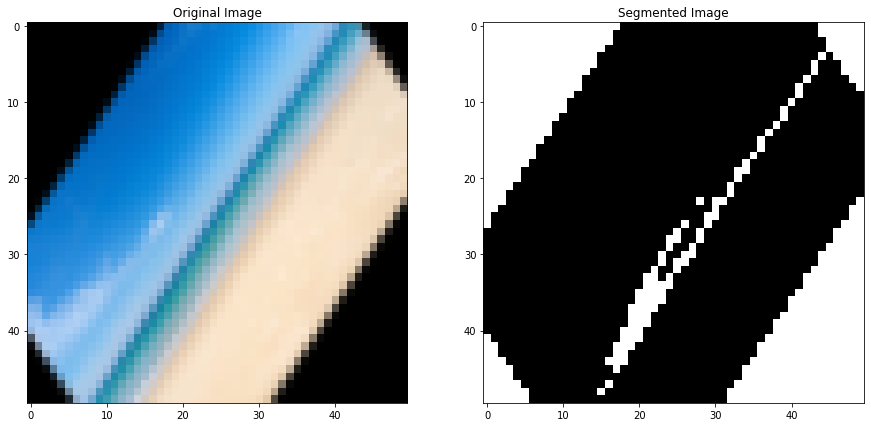

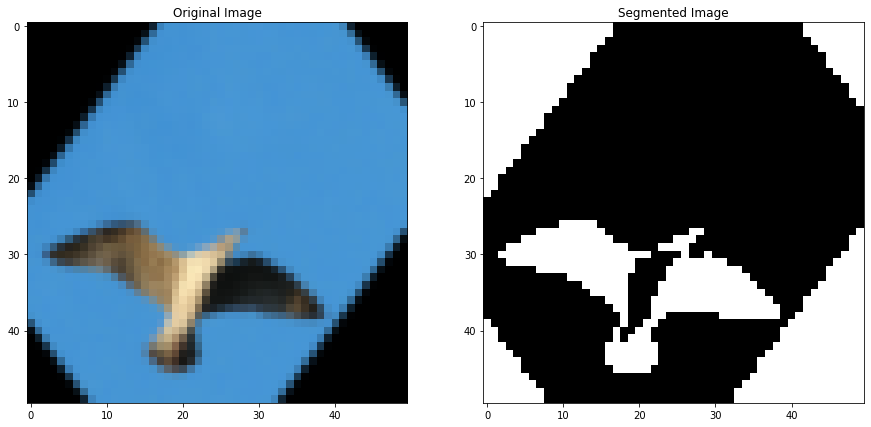

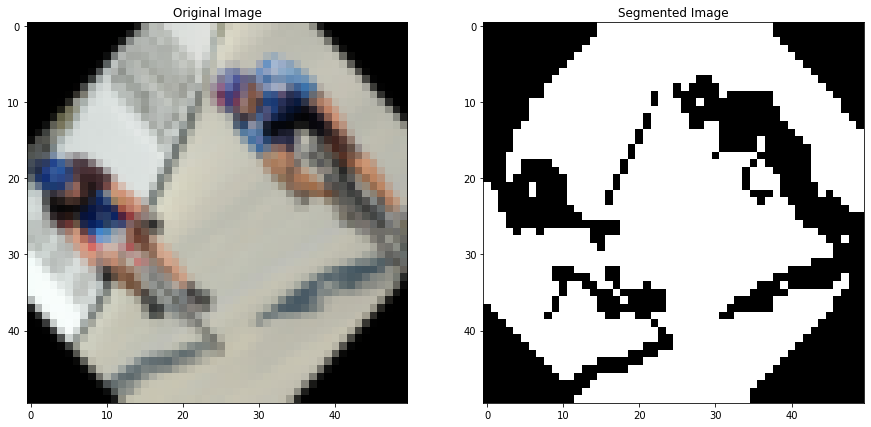

In [85]:
for i in range(1,6):
  if (i == 1):
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.png')
  else:
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.jpg')
  img = skimage.transform.rotate(img,45)
  img, W, second_smallest = n_cut_color(img)
  threshold_and_display_image(img, second_smallest)

## **N-Cut For Gaussian Blurred Images(Based on Color)**

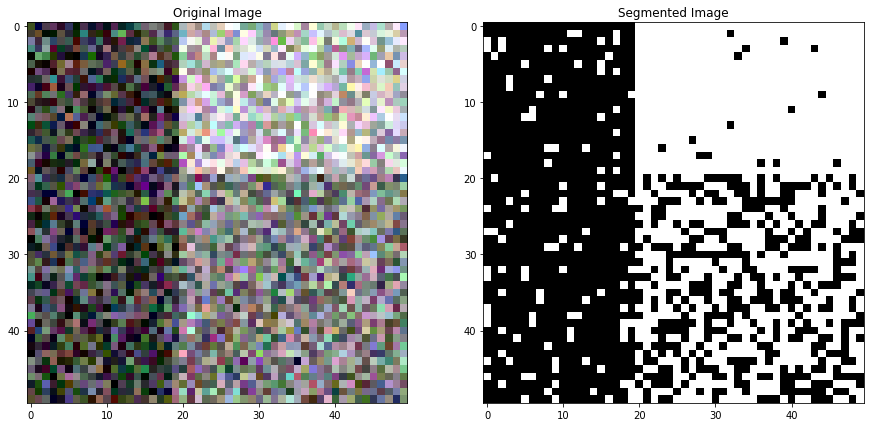

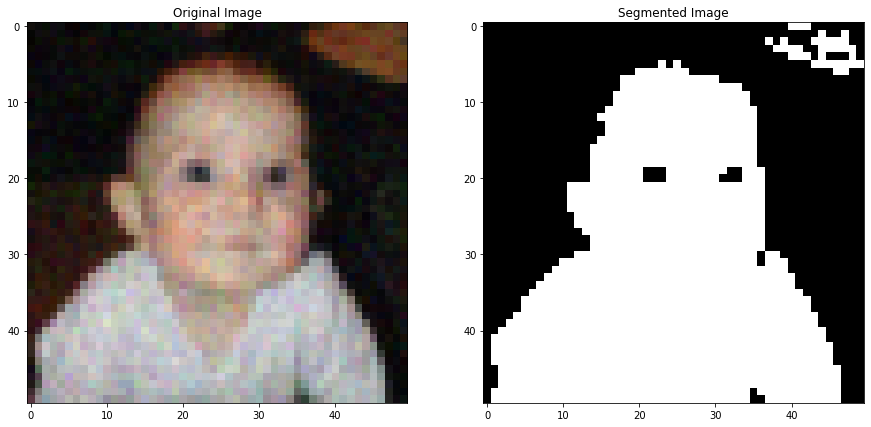

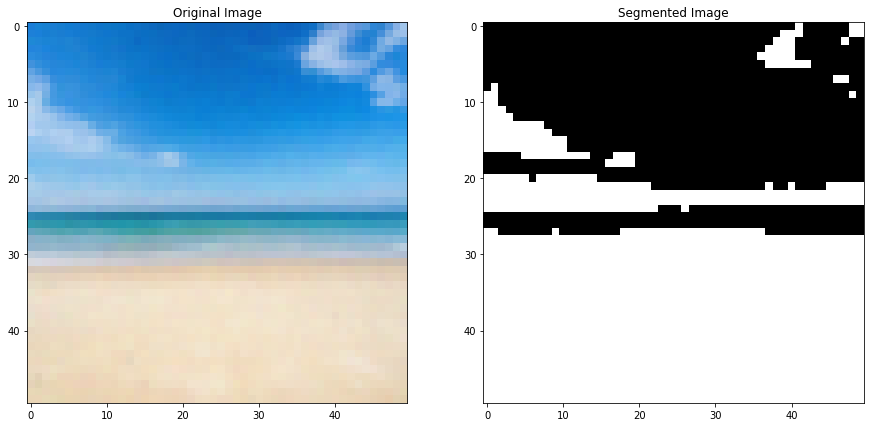

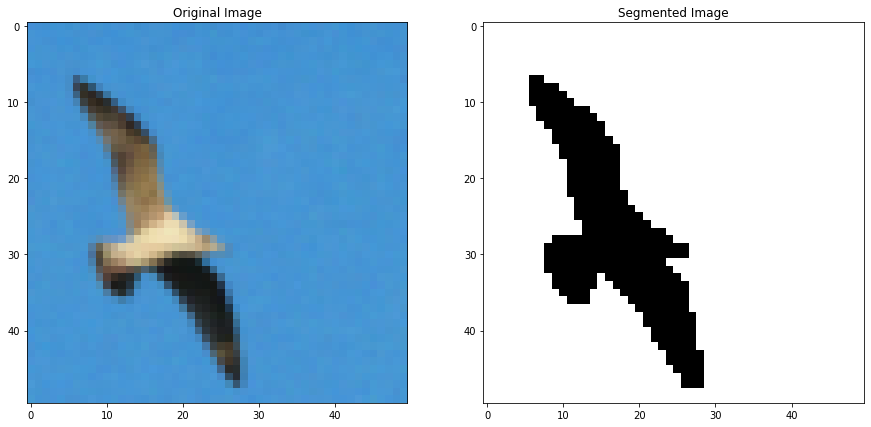

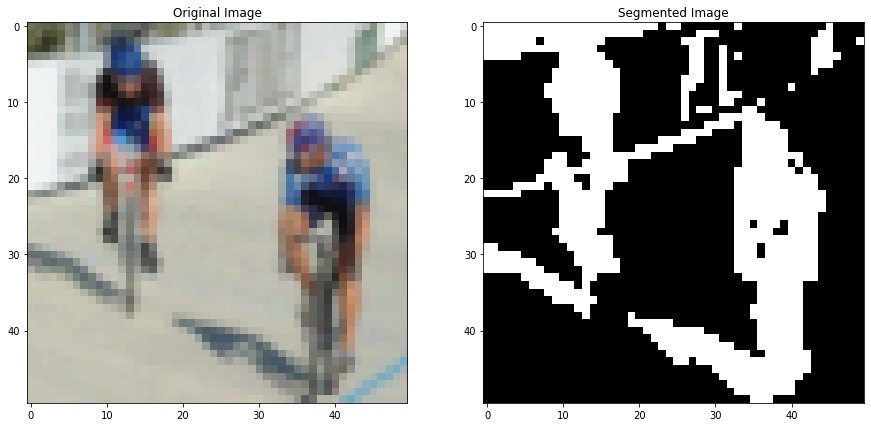

In [86]:
for i in range(1,6):
  if (i == 1):
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.png')
  else:
    img = io.imread('/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment2/test_images/test_images/test'+str(i)+'.jpg')
  img = skimage.util.random_noise(img, mode='gaussian')
  img, W, second_smallest = n_cut_color(img)
  threshold_and_display_image(img, second_smallest)